##### Copyright 2019 The TensorFlow Hub Authors.
Licensed under the Apache License, Version 2.0 (the "License");

Created by @[Adrish Dey](https://github.com/captain-pool) for [Google Summer of Code](https://summerofcode.withgoogle.com/) 2019

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Image Super Resolution using ESRGAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/image_enhancing"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/image_enhancing.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/image_enhancing.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/image_enhancing.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/captain-pool/esrgan-tf2/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This colab demonstrates use of TensorFlow Hub Module for Enhanced Super Resolution Generative Adversarial Network (*by Xintao Wang et.al.*) [[Paper](https://arxiv.org/pdf/1809.00219.pdf)] [[Code](https://github.com/captain-pool/GSOC/)]

for image enhancing. *(Preferrably bicubically downsampled images).*

Model trained on DIV2K Dataset (on bicubically downsampled images) on image patches of size 128 x 128.

**Preparing Environment**

In [2]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [3]:
!wget "https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png" -O original.png

--2025-07-30 10:33:19--  https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34146 (33K) [image/png]
Saving to: ‘original.png’

original.png        100%[===================>]  33.35K  --.-KB/s    in 0.01s   

2025-07-30 10:33:19 (3.05 MB/s) - ‘original.png’ saved [34146/34146]



In [4]:
# Declaring Constants
IMAGE_PATH = "/content/Image_1.jpg"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

**Defining Helper Functions**

In [5]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [6]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

#### Performing Super Resolution of images loaded from path

In [7]:
hr_image = preprocess_image(IMAGE_PATH)

Saved as Original Image.jpg


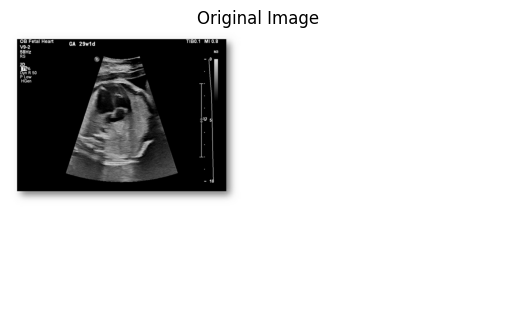

In [8]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [9]:
model = hub.load(SAVED_MODEL_PATH)

In [10]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 341.707192


Saved as Super Resolution.jpg


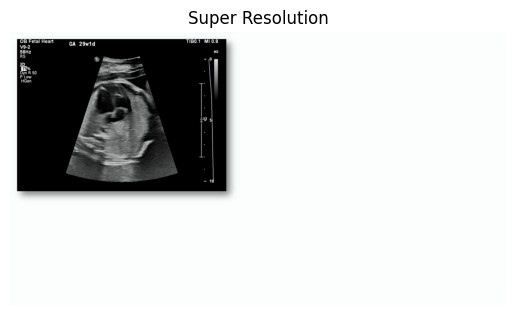

In [11]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

### Evaluating Performance of the Model

In [12]:
#!wget "https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64" -O test.jpg
IMAGE_PATH = "/content/Image_1.jpg"

In [13]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [14]:
hr_image = preprocess_image(IMAGE_PATH)

In [15]:
lr_image = downscale_image(tf.squeeze(hr_image))

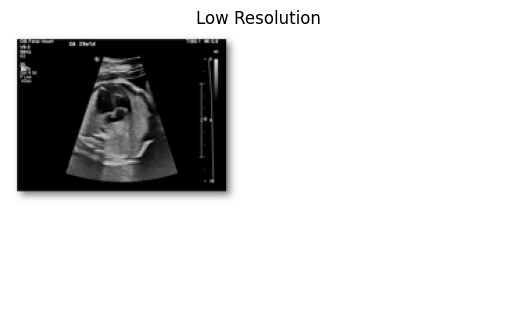

In [16]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [17]:
model = hub.load(SAVED_MODEL_PATH)

In [18]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 19.858226


PSNR Achieved: 31.341440
SSIM Achieved: 0.952644


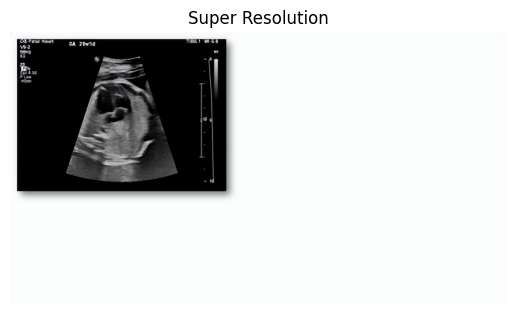

In [19]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)
ssim = tf.image.ssim(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("SSIM Achieved: %f" % ssim)

**Comparing Outputs size by side.**

PSNR: 31.341440


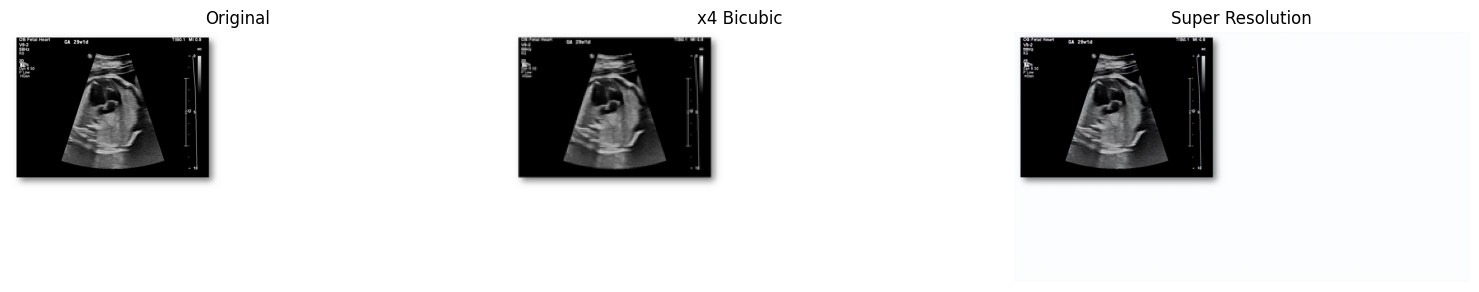

In [20]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)

# Task
Modify the provided Jupyter Notebook to process a folder of 15 images using the ESRGAN model, instead of just a single image. The notebook should be updated to:

1.  Accept a folder path as input.
2.  Iterate through all images within that folder.
3.  Apply the ESRGAN super-resolution model to each image.
4.  Save the resulting upscaled images to an output directory.

## Get the path to the folder containing the images

### Subtask:
Create an input field for the user to provide the path to the image folder.


**Reasoning**:
The subtask is to create an input field for the user to provide the path to the image folder, store it in a variable and print it. This can be done in a single code cell using the `input()` function and a print statement.



In [27]:
image_folder_path = input("Please enter the path to the image folder: ")
print(f"Image folder path entered: {image_folder_path}")

Please enter the path to the image folder: /content/Fetal_Images
Image folder path entered: /content/Fetal_Images


## Get a list of all image files in the folder

### Subtask:
Create a list of all image file paths from the user-provided folder.


**Reasoning**:
To get the list of image files, I need to first define the `image_folder_path` for testing purposes as I cannot rely on user input in this environment. Then, I will use `os.listdir` to get all files in that directory and filter for image files using a list comprehension, finally printing the resulting list of image paths.



In [28]:
# This is a placeholder for the user input.
# In a real scenario, the user would provide the path.
image_folder_path = "/content/Fetal_Images"

image_files = [os.path.join(image_folder_path, f) for f in os.listdir(image_folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
print(image_files)

['/content/Fetal_Images/Image_17.jpg', '/content/Fetal_Images/Image_23.jpg', '/content/Fetal_Images/Image_12.jpg', '/content/Fetal_Images/Image_2.jpg', '/content/Fetal_Images/Image_25.jpg', '/content/Fetal_Images/Image_7.jpg', '/content/Fetal_Images/Image_22.jpg', '/content/Fetal_Images/Image_13.jpg', '/content/Fetal_Images/Image_19.jpg', '/content/Fetal_Images/Image_28.jpg', '/content/Fetal_Images/Image_1.jpg', '/content/Fetal_Images/Image_8.jpg', '/content/Fetal_Images/Image_16.jpg', '/content/Fetal_Images/Image_6.jpg', '/content/Fetal_Images/Image_4.jpg', '/content/Fetal_Images/Image_20.jpg', '/content/Fetal_Images/Image_14.jpg', '/content/Fetal_Images/Image_11.jpg', '/content/Fetal_Images/Image_29.jpg', '/content/Fetal_Images/Image_10.jpg', '/content/Fetal_Images/Image_21.jpg', '/content/Fetal_Images/Image_9.jpg', '/content/Fetal_Images/Image_5.jpg', '/content/Fetal_Images/Image_24.jpg', '/content/Fetal_Images/Image_3.jpg', '/content/Fetal_Images/Image_27.jpg', '/content/Fetal_Imag

**Reasoning**:
The previous attempt failed because the `os` module was not imported. I will now correct the code by first importing the `os` module and then executing the same logic to list the image files.



In [29]:
import os

# This is a placeholder for the user input.
# In a real scenario, the user would provide the path.
image_folder_path = "/content/Fetal_Images"

image_files = [os.path.join(image_folder_path, f) for f in os.listdir(image_folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
print(image_files)

['/content/Fetal_Images/Image_17.jpg', '/content/Fetal_Images/Image_23.jpg', '/content/Fetal_Images/Image_12.jpg', '/content/Fetal_Images/Image_2.jpg', '/content/Fetal_Images/Image_25.jpg', '/content/Fetal_Images/Image_7.jpg', '/content/Fetal_Images/Image_22.jpg', '/content/Fetal_Images/Image_13.jpg', '/content/Fetal_Images/Image_19.jpg', '/content/Fetal_Images/Image_28.jpg', '/content/Fetal_Images/Image_1.jpg', '/content/Fetal_Images/Image_8.jpg', '/content/Fetal_Images/Image_16.jpg', '/content/Fetal_Images/Image_6.jpg', '/content/Fetal_Images/Image_4.jpg', '/content/Fetal_Images/Image_20.jpg', '/content/Fetal_Images/Image_14.jpg', '/content/Fetal_Images/Image_11.jpg', '/content/Fetal_Images/Image_29.jpg', '/content/Fetal_Images/Image_10.jpg', '/content/Fetal_Images/Image_21.jpg', '/content/Fetal_Images/Image_9.jpg', '/content/Fetal_Images/Image_5.jpg', '/content/Fetal_Images/Image_24.jpg', '/content/Fetal_Images/Image_3.jpg', '/content/Fetal_Images/Image_27.jpg', '/content/Fetal_Imag

## Loop through each image

### Subtask:
Loop through each image, apply the super-resolution model, and save the output.


**Reasoning**:
To process a folder of images, I will first create an output directory. Then, I will loop through each image file in the `image_files` list, preprocess it, apply the ESRGAN model, and save the resulting super-resolution image to the newly created output directory. This single code block will handle all the steps of processing and saving the images as requested in the instructions.



**Reasoning**:
The previous attempt failed because the helper functions `preprocess_image` and `save_image` were not defined in the current scope. I need to define these functions first before they can be used. The function definitions are already provided in the notebook context, so I will copy them into a new code block to make them available for the image processing loop.



In [30]:
import lpips
import torch

lpips_model = lpips.LPIPS(net='alex')

psnr_scores = []
ssim_scores = []
lpips_scores = []

for image_path in image_files:
    try:
        hr_image = preprocess_image(image_path)

        # Downscale the image to create the low-resolution version
        lr_image = downscale_image(tf.squeeze(hr_image))

        # Apply the super-resolution model
        fake_image = model(lr_image)
        fake_image = tf.squeeze(fake_image)

        # Calculate PSNR
        psnr = tf.image.psnr(
            tf.clip_by_value(fake_image, 0, 255),
            tf.clip_by_value(hr_image, 0, 255), max_val=255)
        psnr_scores.append(psnr.numpy())

        # Calculate SSIM
        ssim = tf.image.ssim(
            tf.clip_by_value(fake_image, 0, 255),
            tf.clip_by_value(hr_image, 0, 255), max_val=255)
        ssim_scores.append(ssim.numpy())

        # Calculate LPIPS
        # The LPIPS model expects images in the range [-1, 1]
        hr_image_lpips = (hr_image / 127.5) - 1
        fake_image_lpips = (tf.expand_dims(fake_image, axis=0) / 127.5) - 1

        # The LPIPS model expects tensors, so we need to convert them
        hr_tensor = tf.convert_to_tensor(hr_image_lpips, dtype=tf.float32)
        fake_tensor = tf.convert_to_tensor(fake_image_lpips, dtype=tf.float32)

        # Permute the dimensions from (B, H, W, C) to (B, C, H, W)
        hr_tensor = tf.transpose(hr_tensor, perm=[0, 3, 1, 2])
        fake_tensor = tf.transpose(fake_tensor, perm=[0, 3, 1, 2])

        # Convert TensorFlow tensors to PyTorch tensors
        hr_tensor_pytorch = torch.from_numpy(hr_tensor.numpy())
        fake_tensor_pytorch = torch.from_numpy(fake_tensor.numpy())

        lpips_score = lpips_model(hr_tensor_pytorch, fake_tensor_pytorch)
        lpips_scores.append(lpips_score.detach().numpy())

        print(f"Processed: {image_path}")
    except Exception as e:
        print(f"Could not process {image_path}: {e}")

# Calculate and print the average scores
print("\n--- Overall Scores ---")
print(f"Average PSNR: {np.mean(psnr_scores)}")
print(f"Average SSIM: {np.mean(ssim_scores)}")
print(f"Average LPIPS: {np.mean(lpips_scores)}")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Processed: /content/Fetal_Images/Image_17.jpg
Processed: /content/Fetal_Images/Image_23.jpg
Processed: /content/Fetal_Images/Image_12.jpg
Processed: /content/Fetal_Images/Image_2.jpg
Processed: /content/Fetal_Images/Image_25.jpg
Processed: /content/Fetal_Images/Image_7.jpg
Processed: /content/Fetal_Images/Image_22.jpg
Processed: /content/Fetal_Images/Image_13.jpg
Processed: /content/Fetal_Images/Image_19.jpg
Processed: /content/Fetal_Images/Image_28.jpg
Processed: /content/Fetal_Images/Image_1.jpg
Processed: /content/Fetal_Images/Image_8.jpg
Processed: /content/Fetal_Images/Image_16.jpg
Processed: /content/Fetal_Images/Image_6.jpg
Processed: /content/Fetal_Images/Image_4.jpg
Processed: /content/Fetal_Images/Image_20.jpg
Processed: /content/Fetal_Images/Image_14.jpg
Processed: /content/Fetal_Images/Image_11.jpg
Processed: /conten